In [1]:
import numpy as np
import matplotlib.pyplot as plt

$\tilde t = t / (\frac{m\sigma^2}{\epsilon})^{1/2}$

$\tilde x = x/\sigma$

$\tilde v = v/\sqrt{\epsilon/m}$

$\tilde U (\tilde r) = U(r)/\epsilon$

Kinetic energy in natural units: $\tilde K(\tilde v) = \frac{K(v)}{\epsilon}= \frac{1}{2 \epsilon}m\tilde v^2 \frac{\epsilon}{m} = \frac{1}{2}\tilde v^2$

$\nabla = \frac{1}{\sigma} \tilde\nabla$

In [2]:
n = 3   #number of particles
L = 1000   #System is of size LxL with the origin at the center. The units of L are of 1/s
init_pos = np.array([[0, 0, 0],[L-1, L-1, L-1], [847, 325, 638]])
#init_vel = np.zeros((n, 3))
#init_vel = np.array([[0.1, 0.1, 0.1],[0.1, 0.1, 0.1], [0.1, 0.1, 0.1]])
init_vel = np.random.normal(0, 1, size = (n, 3))
#init_vel_center = (1/n)*np.sum(init_vel_notnorm, axis = 0)
e =  1.65 * pow(10,-21)
s =  3.405 * pow(10,-10)
time_step = float(1e-4)
m =  6.6335 * pow(10, -26) #mass of argon atom in kg

#number_of_steps = 2000         #strange that verlet and euler give exact same result...
number_of_steps = int(100000)       # here we see verlet doesn't let the energy diverge. still oscillates
dimensions = 3



In [3]:
#print("initial pos\n", init_pos,"\n initial vel\n" ,init_vel)
times = np.arange(0,(number_of_steps + 1) * time_step, time_step)

In [4]:
W = L   #Width 
K = L   #Depth
def atomic_distances(pos, output, L=1, W=1): # output = 0 gives the relative distances, output = 1 gives the relative positions
    rel_pos = pos[:, None, :] - pos[None, :, :]                 # returns one matrix for each particle. Relative distances within the box
    rel_dist = np.zeros((n, n, 1))
    for i in range(n):
        for k in range(n):
            for l in range(dimensions):
                if l == 0: # x-values i.e. change by L
                    rel_pos[i,k,l] = min(rel_pos[i,k,l], (rel_pos[i,k,l]+L)%L, (rel_pos[i,k,l]-L)%L, rel_pos[i,k,l]+L, rel_pos[i,k,l]-L, key=abs) # takes the smallest distance comparing all images
                if l == 1:
                    rel_pos[i,k,l] = min(rel_pos[i,k,l], (rel_pos[i,k,l]+W)%W, (rel_pos[i,k,l]-W)%W, rel_pos[i,k,l]+W, rel_pos[i,k,l]-W, key=abs)
                if l == 2:
                    rel_pos[i,k,l] = min(rel_pos[i,k,l], (rel_pos[i,k,l]+K)%K, (rel_pos[i,k,l]-K)%K, rel_pos[i,k,l]+K, rel_pos[i,k,l]-K, key=abs)
    for i in range(n):    
        for k in range(n):
            rel_dist[i,k] = np.sqrt(np.dot(rel_pos[i,k,:],rel_pos[i,k,:]))
    
    if output == 0:
        return rel_dist
    elif output == 1:
        return rel_pos
    else:
        print("The second parameter in the lj_forces must be either 0(for distances) or 1(for positions)")

In [5]:
#compute the forces on the particles at each timestep

def lj_force(position, n):
    rel_pos = atomic_distances(position[:,-3:], 1) # calculates the relative position of the particles, with pos = np.array(N_particels, 3)
    n = np.shape(rel_pos)[0] # number of particles
    r = np.sqrt(np.sum((rel_pos)**2, axis=2)) # n x n simmetric matrix, r[i,j] is the distance between the i-th and the j-th particles
    R = np.zeros((n,n,3))
    for i in range(n):
        for j in range (n):
            for k in range (3):
                R[i,j,k] = r [i,j]
                if r[i,j] == 0:
                    R[i,j,k] = 1
    # R are n matricies in the form nx3, where the i-th matrix contains the distances from the i-th particle, calling R_i the i-th matrix, 
    # R_i[j,k] gives the distance between the i-th and the j-th particles and is the same value for all the 'k in range(3)', i.e. on all the j-th line
    # in addition, R_i[i,k] (i-th line of the i-th matrix) is equal to 1 instead of 0 in order not to divide by 0 in the computation of F
    # we can do this since rel_pos_i[i,k] multiplies everything in F and is equal to 0
    F = np.zeros((n,n,3))
    F = rel_pos*R
    F = -24*rel_pos*((2*(1/R)**12)-((1/R)**6))
    F_matrix = np.sum(F, axis=0)  
    return F_matrix # The output is an nx3 matrix

In [6]:
def euler(final_matrix_pos, final_matrix_vel):
    latest_pos = np.copy(final_matrix_pos[:,-3:])# -3 is for the dimensions
    latest_vel = np.copy(final_matrix_vel[:,-3:])
    
    new_latest_pos = latest_pos + latest_vel * time_step
    new_latest_vel = latest_vel + time_step * lj_force(latest_pos, n)
    return new_latest_pos, new_latest_vel

def verlet(final_matrix_pos, final_matrix_vel):
    
    latest_pos = np.copy(final_matrix_pos[:,-3:])# -3 is for the dimensions
    latest_vel = np.copy(final_matrix_vel[:,-3:])
    
    new_latest_pos = latest_pos + time_step * latest_vel + (1/2) * time_step**2  * lj_force(latest_pos, n)
    new_latest_vel = latest_vel + (time_step/2) * (lj_force(new_latest_pos, n) + lj_force(latest_pos, n))
    return new_latest_pos, new_latest_vel


In [7]:
#function to compute the kinetic energy
def kin_en(v): #v is the last step velocity
    K = 0.5*np.sum(v**2)
    return K

In [8]:
#function to compute the potential energy
def pot_en(position): #position is the matrix with all the positions stored in it
    current_pos = np.copy(position[:,-3:]) #nx3 matrix with the positions at the last time step
    rel_pos = atomic_distances(current_pos, 1) # with pos = np.array(n, 3)
    r = np.sqrt(np.sum((rel_pos)**2, axis=2)) #n x n simmetric matrix, r[i,j] is the distance between the i-th and the j-th particles
    i = np.where(r == 0) # indices where the r matrix is 0
    ones = np.zeros((n,n)) # nxn matrix
    ones[i] = 1 # matrix with ones where r has zeros
    R = r + ones  # same matrix as r, but with ones where r has zeros. we do this to avoid dividing by zero
    u = 4*(1/R**12 - 1/R**6)
    U = np.sum(u)
    return U
pot_en(init_pos)

-7.169479379250347e-15

using Euler:

Init energy: [5.13285632]
Frank




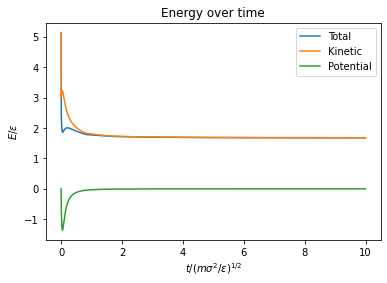

using Verlet:

Init energy: [5.13285632]
Frank



KeyboardInterrupt: 

In [9]:
def simulate(algorithm):
    #Create a 2x8 matrix to store the velocity of each particle at each step in time.
    next_step_velocity = np.copy(init_vel)

    #Create a 2x8 matrix to store the position of each particle at each step in time.
    next_step_position = np.copy(init_pos)
    
    final_matrix_pos = np.copy(init_pos)
    final_matrix_vel = np.copy(init_vel)
    
    final_vector_kin = np.array([kin_en(init_vel)])
    final_vector_pot = np.array([pot_en(final_matrix_pos)])
    final_vector_energy = np.array([kin_en(init_vel) + pot_en(final_matrix_pos)])
    
    print("Init energy:" , final_vector_energy)

    final_rel_dist = atomic_distances(init_pos, 0)
    

    for i in range(number_of_steps):
        next_step_position, next_step_velocity = algorithm(final_matrix_pos, final_matrix_vel)
        next_step_position = next_step_position % L
        final_matrix_pos =  np.concatenate((final_matrix_pos, next_step_position), axis=1, out=None)
        final_matrix_vel =  np.concatenate((final_matrix_vel, next_step_velocity), axis=1, out=None)
        final_vector_kin = np.concatenate((final_vector_kin, np.array([kin_en(next_step_velocity)])), axis = 0, out = None)
        final_vector_pot = np.concatenate((final_vector_pot, np.array([pot_en(final_matrix_pos)])), axis=0, out=None)
        final_vector_energy = np.concatenate((final_vector_energy, np.array([kin_en(next_step_velocity) + pot_en(final_matrix_pos)])), axis=0, out=None)
        final_rel_dist = np.concatenate((final_rel_dist, atomic_distances(next_step_position, 0)), axis = 1, out = None)
        
        
        if i%100 == 0 and abs(final_vector_energy[-1] - final_vector_energy[-2])> 0.01:
            print("Frank\n")
            l = np.sqrt((3*(n-1))/(2*final_vector_kin[-1]))
            final_matrix_vel = final_matrix_vel * l

    #print("Positions:\n" , final_matrix_pos)
    #print("Velocities:\n" , init_vel)
    #print("Energy:\n" , final_vector_pot)
    #print(final_vector_energy)
    #print(final_vector_pot)
    #print(final_rel_dist)


    print("")
    plt.plot(times, final_vector_energy, label = "Total")
    plt.plot(times, final_vector_kin, label = "Kinetic")
    plt.plot(times, final_vector_pot, label = "Potential")
    plt.legend()
    plt.title("Energy over time")
    plt.xlabel("$t/(m\sigma^2/\epsilon)^{1/2}$")
    plt.ylabel("$E/\epsilon$")
    plt.show()
    
print("using Euler:\n")
simulate(euler)
print("using Verlet:\n")
simulate(verlet)
